In [1]:
# This notebeook is for displaying statistics about the ood dataset split

In [2]:
# load corpus dataset
from src.data.create_corpus_dataset import create_dataset, DatasetConfig, UtteranceType, DatasetSplitType
import os
from datasets import load_from_disk
from src.data.dataset_splits import create_splits_from_corpus_dataset
from collections import defaultdict
import pandas as pd

# load dataset
dataset_folder = "../../data/processed/with_context"
dataset_path = os.path.join(dataset_folder, "corpus_dataset_v2")
output_directory = "../../reports/dataset_statistics/corpus_dataset_v2/split_out_of_distribution_label"

os.makedirs(output_directory, exist_ok=True)
if not os.path.exists(dataset_path):
    # Beispiel zum Erstellen eines Datensatzes. Mögliche Optionen von DatasetConfig sind im DocString beschrieben.
    create_dataset(
        DatasetConfig(
            dataset_path=dataset_path,
            project_dir="../../",
            num_previous_turns=3,
            include_role=True,
            sep_token="[SEP]",
            utterance_type=UtteranceType.User,
            eval_size=0.5,
            validation_test_ratio=0.5
        )
    )

# Beispiel zum Laden des Datensatzes + collate_function des DataLoaders um dynamisch ein Subset der negative passages zu laden.
corpus_dataset = load_from_disk(dataset_path)

/home/christian/PycharmProjects/ethikchat-experiment-argument-classification/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
    # Create an Out-of-Distribution (Simple) split
ood_split_simple = create_splits_from_corpus_dataset(
    corpus_dataset,
    dataset_split_type=DatasetSplitType.OutOfDistributionSimple,
    save_folder=dataset_folder,
    dataset_save_name="dataset_out_of_distribution_label",
    seed=42
)
ood_split_simple["train"]["queries"]


Dataset already exists at ../../data/processed/with_context/dataset_out_of_distribution_label. Loading it.


/home/christian/PycharmProjects/ethikchat-experiment-argument-classification/src/data/dataset_splits.py:107: UserWarning: Overlapping texts between train and validation (but no overlapping query ids, so theses are not the same anchors): 1
Example texts: ['Sicherheit']
  warnings.warn(


Dataset({
    features: ['id', 'text', 'labels', 'discussion_scenario', 'context', 'scenario_description', 'scenario_question'],
    num_rows: 1981
})

In [4]:
# Count labels per scenario and split
label_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for split in ["train", "validation", "test"]:
    for query in ood_split_simple[split]["queries"]:
        scenario = query["discussion_scenario"]
        for label in query["labels"]:
            label_counts[split][scenario][label] += 1

# Build dataframe
records = []
for split, split_dict in label_counts.items():
    for scenario, labels in split_dict.items():
        for label, count in labels.items():
            records.append({
                "scenario": scenario,
                "label": label,
                "split": split,
                "count": count
            })

dataframe = pd.DataFrame(records)
dataframe

,scenario,label,split,count
0,MEDAI,Z.K1,train,135
1,MEDAI,Z.P1-1-1,train,10
2,MEDAI,Z.P3,train,17
3,MEDAI,Z.P5,train,34
4,MEDAI,Z.P4-1,train,22
...,...,...,...,...
294,REFAI,Z.P1-3-1,test,1
295,REFAI,Z.K9,test,4
296,REFAI,Z.K8,test,3
297,REFAI,Z.P9-1,test,1


In [5]:
ood_split_simple["buckets"]


Dataset({
    features: ['Scenario', 'bucket', 'label', 'freq'],
    num_rows: 219
})

✓ All counts for MEDAI match between pivot_df and buckets data


split,test,train,validation,total,bucket
label,,,,,
NZ.K10,4.0,184.0,3.0,191.0,0
Z.K1,1.0,135.0,2.0,138.0,0
Z.K7,1.0,113.0,0.0,114.0,0
Z.K2,0.0,80.0,1.0,81.0,0
Z.K14,0.0,57.0,2.0,59.0,0
...,...,...,...,...,...
Z.K3-1-1,1.0,0.0,0.0,1.0,4
Z.K6-1,0.0,1.0,0.0,1.0,4
Z.K8-2,0.0,1.0,0.0,1.0,4


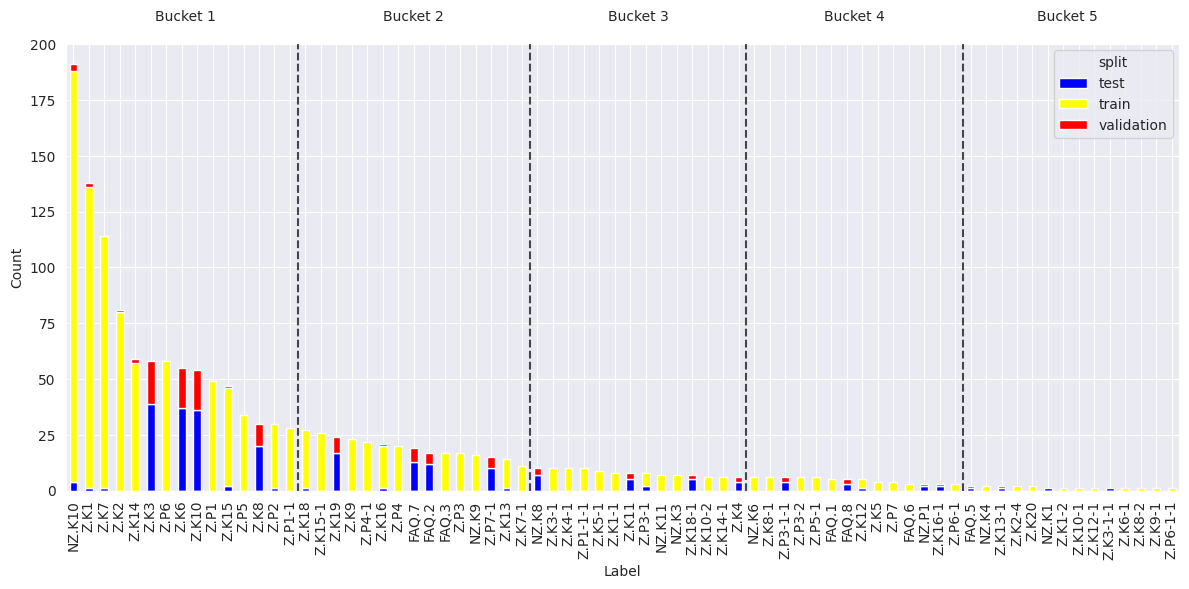

✓ All counts for JURAI match between pivot_df and buckets data


split,test,train,validation,total,bucket
label,,,,,
Z.P1-1,27.0,0.0,13.0,40.0,0
Z.P1,1.0,27.0,0.0,28.0,0
Z.P2,0.0,21.0,0.0,21.0,0
Z.P4-1,0.0,21.0,0.0,21.0,0
Z.K2,0.0,19.0,0.0,19.0,0
Z.K14,0.0,16.0,0.0,16.0,0
Z.P8,0.0,16.0,0.0,16.0,0
NZ.K10,10.0,0.0,5.0,15.0,0
Z.K4,9.0,0.0,4.0,13.0,0


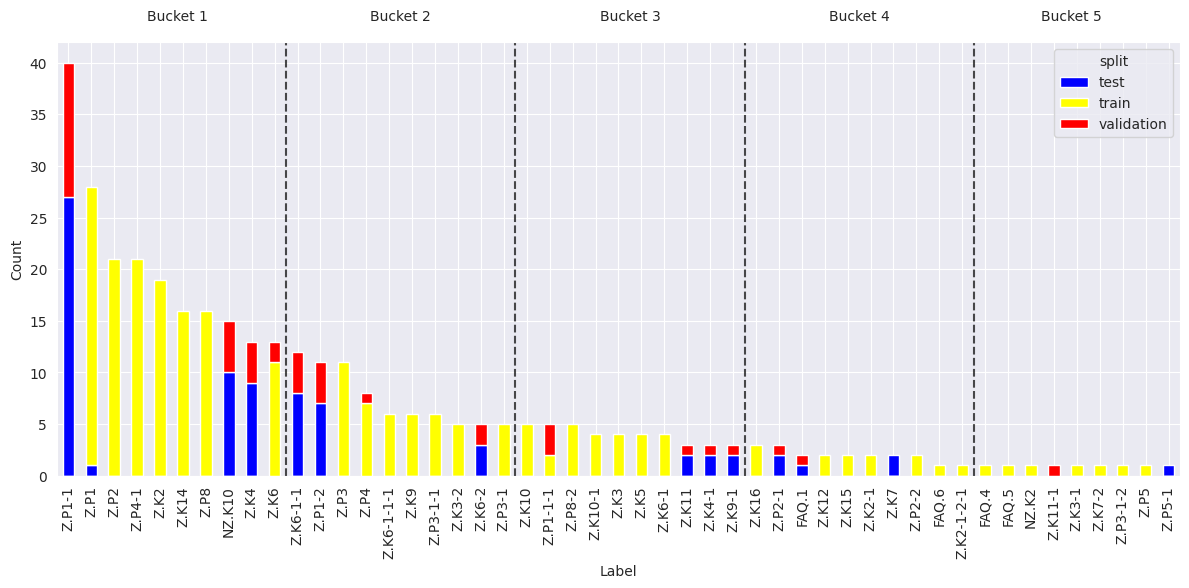

✓ All counts for AUTOAI match between pivot_df and buckets data


split,test,train,validation,total,bucket
label,,,,,
Z.P11,89.0,0.0,43.0,132.0,0
Z.C3,38.0,0.0,17.0,55.0,0
Z.P12,2.0,53.0,0.0,55.0,0
Z.P8-1-2,0.0,50.0,0.0,50.0,0
Z.C11,1.0,35.0,0.0,36.0,0
...,...,...,...,...,...
Z.P8-1-2-1,0.0,2.0,0.0,2.0,4
Z.C5-1-1,0.0,0.0,1.0,1.0,4
Z.C6-3,0.0,1.0,0.0,1.0,4


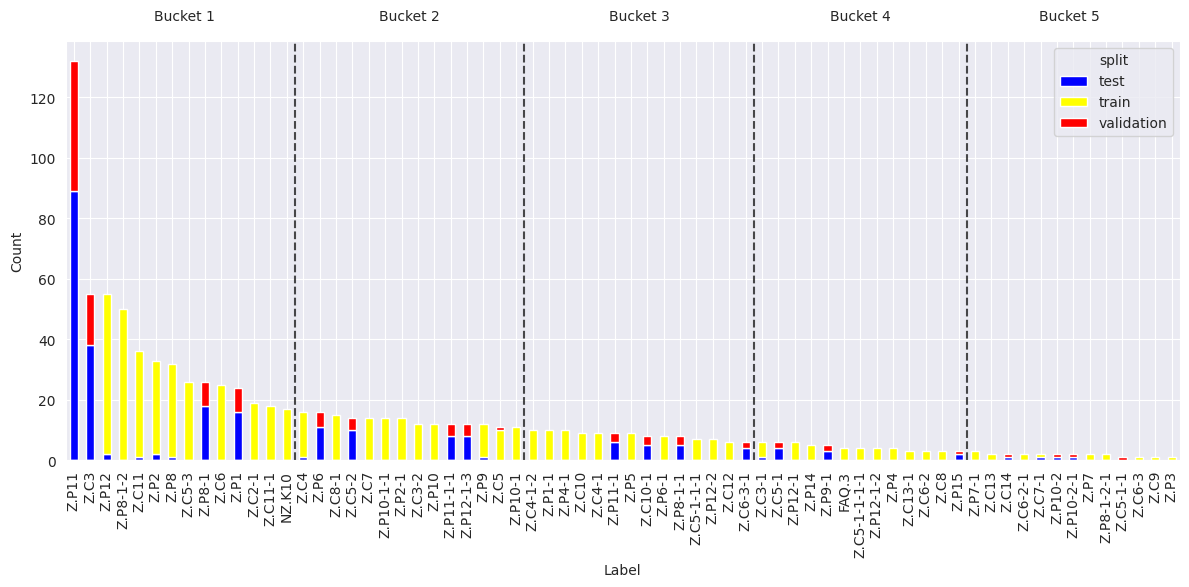

✓ All counts for REFAI match between pivot_df and buckets data


split,test,train,validation,total,bucket
label,,,,,
Z.P2,0.0,16.0,0.0,16.0,0
Z.K5,0.0,13.0,0.0,13.0,0
Z.K9,4.0,0.0,2.0,6.0,0
Z.K1,0.0,5.0,0.0,5.0,0
Z.K3,0.0,5.0,0.0,5.0,0
Z.P1,0.0,5.0,0.0,5.0,0
Z.P5,0.0,5.0,0.0,5.0,1
Z.K8,3.0,0.0,1.0,4.0,1
Z.P6,0.0,4.0,0.0,4.0,1


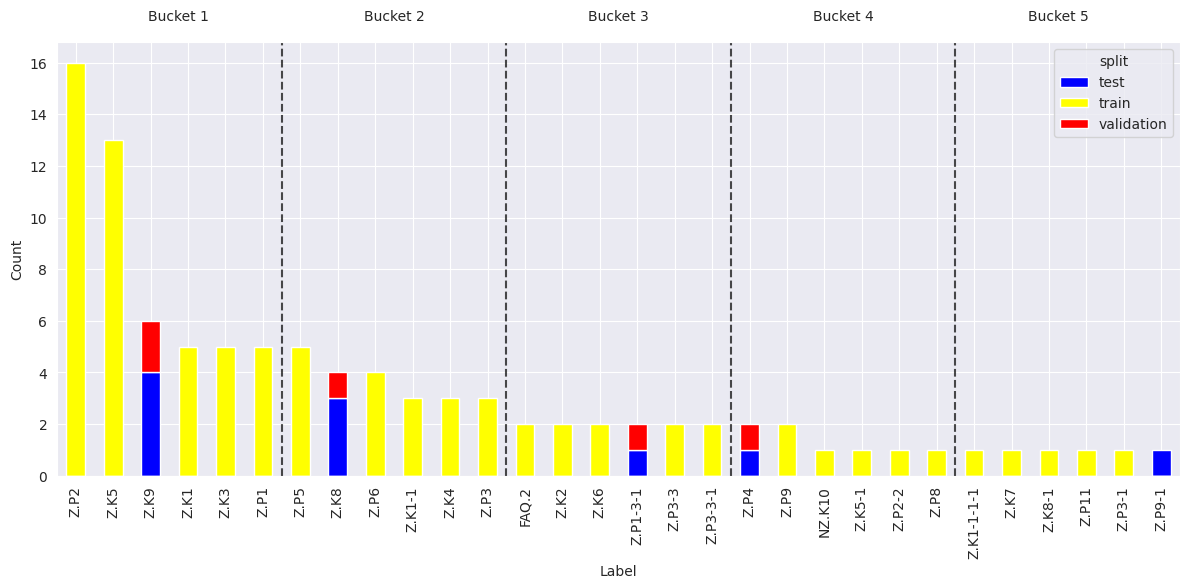

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plot stacked bar chart per scenario
scenarios = dataframe["scenario"].unique()
for scenario in scenarios:
    df_scenario = dataframe[dataframe["scenario"] == scenario]

    # Create the pivot table
    pivot_df = df_scenario.pivot(index="label", columns="split", values="count").fillna(0)
    pivot_df['total'] = pivot_df['train'] + pivot_df['validation'] + pivot_df['test']

    # Get bucket data for this scenario - using filter instead of boolean indexing
    scenario_buckets_df = pd.DataFrame(ood_split_simple["buckets"])
    scenario_buckets = scenario_buckets_df[scenario_buckets_df["Scenario"] == scenario]

    # Create mappings from label to bucket and frequency
    label_to_bucket = dict(zip(scenario_buckets["label"], scenario_buckets["bucket"]))
    label_to_freq = dict(zip(scenario_buckets["label"], scenario_buckets["freq"]))

    # Check if total counts align
    mismatch_found = False
    for label in pivot_df.index:
        pivot_total = pivot_df.loc[label, 'total']
        bucket_freq = label_to_freq.get(label, 0)
        if abs(pivot_total - bucket_freq) > 1e-10:  # Using small epsilon for float comparison
            print(f"Warning: Count mismatch for label '{label}': pivot_df={pivot_total}, buckets={bucket_freq}")
            mismatch_found = True

    if not mismatch_found:
        print(f"✓ All counts for {scenario} match between pivot_df and buckets data")

    # Add bucket information to pivot_df
    pivot_df['bucket'] = pd.Series(pivot_df.index).map(label_to_bucket).values

    # Sort by bucket and then by total within each bucket
    pivot_df = pivot_df.sort_values(['bucket', 'total'], ascending=[True, False])

    display(pivot_df)

    # Plot without the bucket and total columns
    plot_df = pivot_df.drop(columns=['bucket', 'total'])

    ax = plot_df.plot(kind="bar", stacked=True, color=["blue", "yellow", "red"], figsize=(12, 6))
    # plt.title(f"Label Distribution in {scenario}")
    plt.ylabel("Count")
    plt.xlabel("Label")
    plt.xticks(rotation=90)

    # Add vertical lines at bucket boundaries
    bucket_boundaries = []
    current_bucket = -1
    for i, (idx, row) in enumerate(pivot_df.iterrows()):
        if row['bucket'] != current_bucket:
            current_bucket = row['bucket']
            if i > 0:
                bucket_boundaries.append(i - 0.5)

    # Add vertical lines at bucket boundaries
    for boundary in bucket_boundaries:
        plt.axvline(x=boundary, color='black', linestyle='--', alpha=0.7)

    # Add bucket annotations at the top
    current_bucket = 0
    bucket_starts = [0] + bucket_boundaries
    bucket_ends = bucket_boundaries + [len(pivot_df) - 1]

    for start, end in zip(bucket_starts, bucket_ends):
        center = (start + end) / 2
        plt.text(center, ax.get_ylim()[1] * 1.05, f"Bucket {current_bucket +1}",
                 horizontalalignment='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
        current_bucket += 1

    plt.tight_layout()
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


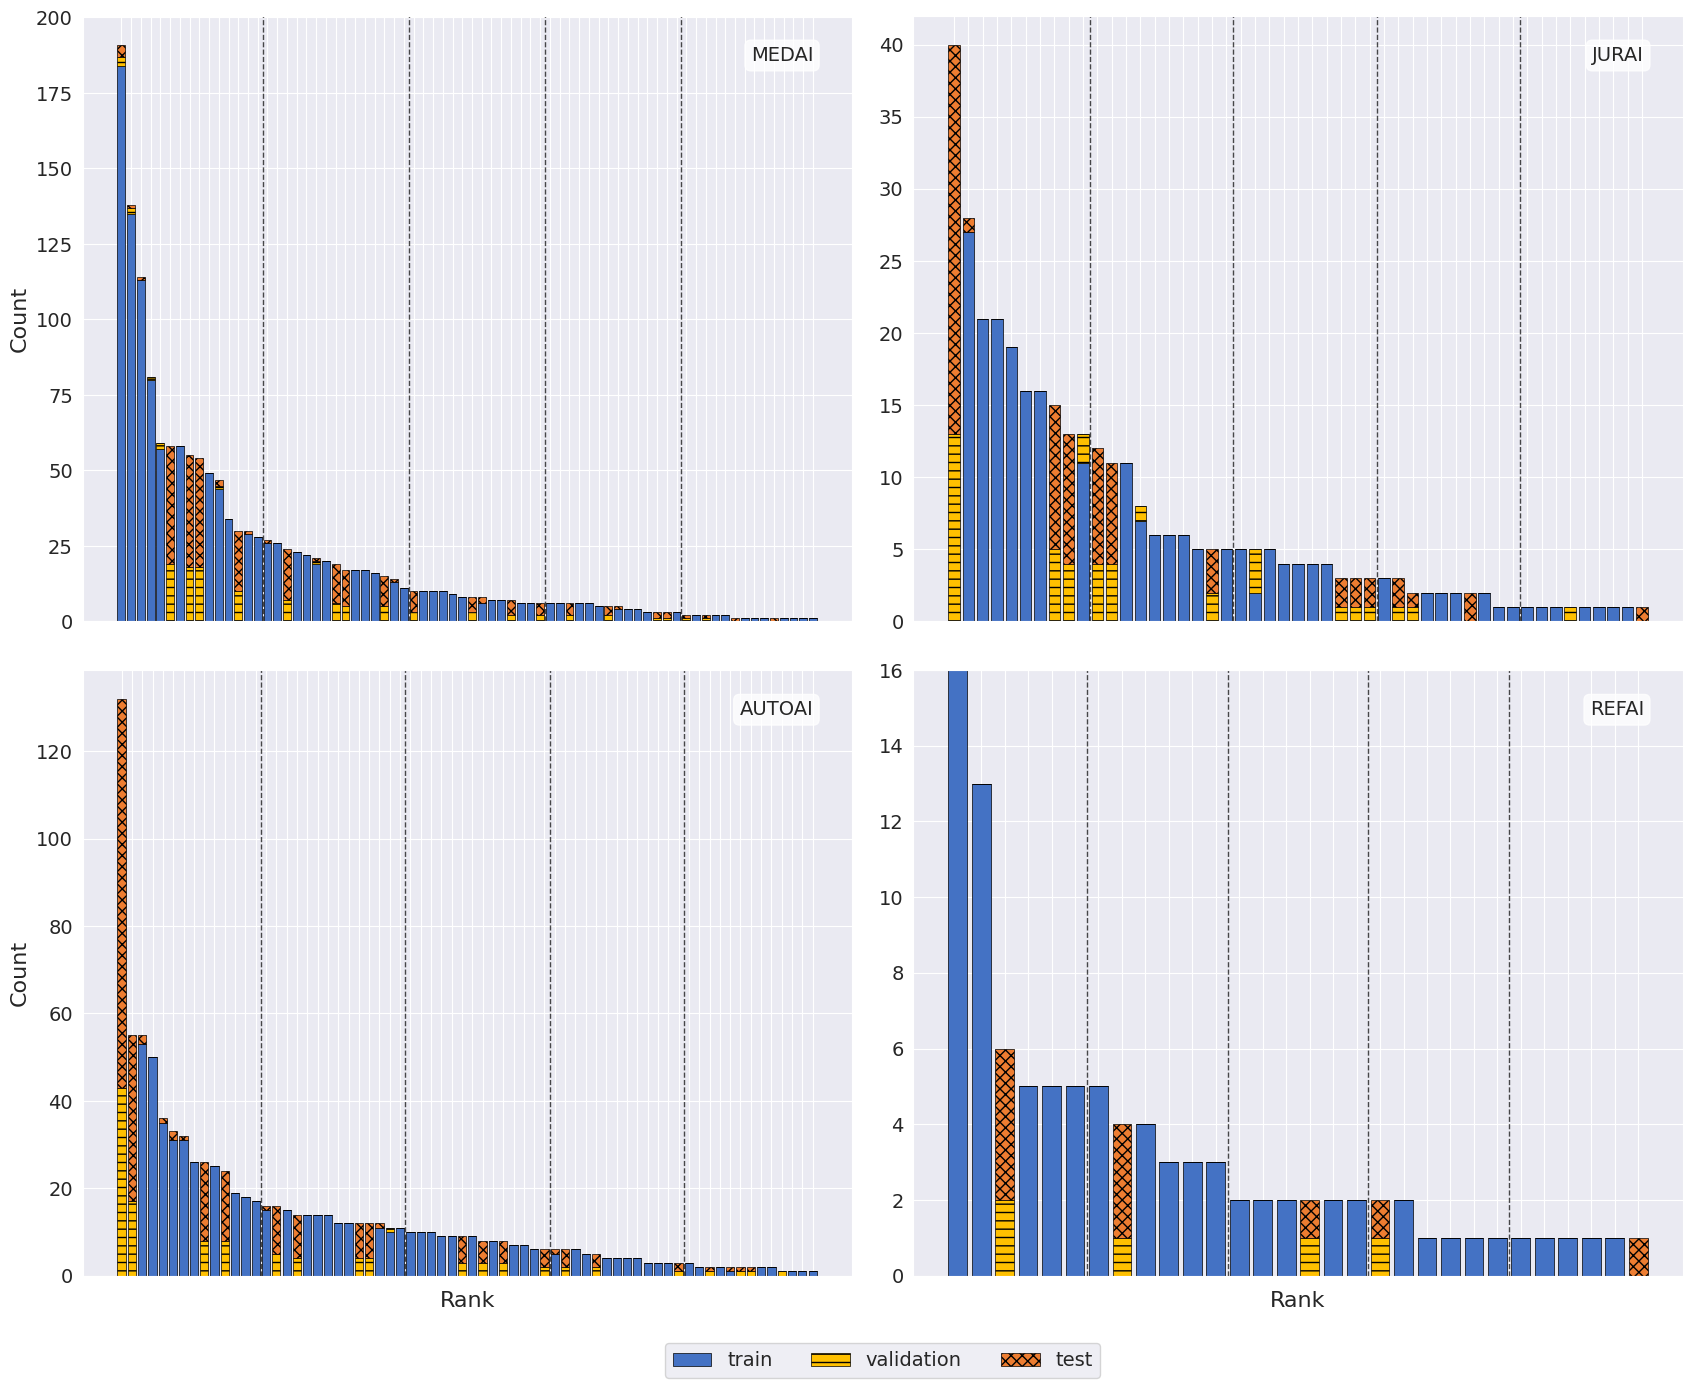

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd

# Font setup without LaTeX
plt.rcParams.update({
    "text.usetex": False,  # Disable LaTeX rendering
    # "font.family": "serif",
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12
})

# Create a 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()  # Flatten to make it easier to iterate

# Define colors and hatching patterns for better distinction
colors = ['#4472C4', '#FFC000', '#ED7D31']  # Blue, Yellow, Red
hatches = ['', '--', 'xxx']

# Scenario counter
scenario_counter = 0

# Store handles and labels for a single legend
handles, labels = None, None

# Plot stacked bar chart per scenario
scenarios = dataframe["scenario"].unique()
for scenario in scenarios:
    if scenario_counter >= 4:  # Ensure we only plot 4 scenarios
        break

    ax = axes[scenario_counter]
    df_scenario = dataframe[dataframe["scenario"] == scenario]

    # Create the pivot table
    pivot_df = df_scenario.pivot(index="label", columns="split", values="count").fillna(0)
    pivot_df['total'] = pivot_df['train'] + pivot_df['validation'] + pivot_df['test']

    # Get bucket data for this scenario
    scenario_buckets_df = pd.DataFrame(ood_split_simple["buckets"])
    scenario_buckets = scenario_buckets_df[scenario_buckets_df["Scenario"] == scenario]

    # Create mappings from label to bucket and frequency
    label_to_bucket = dict(zip(scenario_buckets["label"], scenario_buckets["bucket"]))
    label_to_freq = dict(zip(scenario_buckets["label"], scenario_buckets["freq"]))

    # Add bucket information to pivot_df
    pivot_df['bucket'] = pd.Series(pivot_df.index).map(label_to_bucket).values

    # Sort by bucket and then by total within each bucket
    pivot_df = pivot_df.sort_values(['bucket', 'total'], ascending=[True, False])

    # Plot without the bucket and total columns
    plot_df = pivot_df.drop(columns=['bucket', 'total'])

    # Instead of using plot_df.plot, we'll plot each part separately to add hatching
    # Create the x positions
    x = np.arange(len(plot_df.index))
    width = 0.8

    # Plot each split
    bottom = np.zeros(len(plot_df.index))
    for i, (split, color, hatch) in enumerate(zip(['train', 'validation', 'test'], colors, hatches)):
        heights = plot_df[split].values
        bars = ax.bar(x, heights, width, bottom=bottom, label=split, color=color, edgecolor='black', linewidth=0.5)

        # Add hatching to the bars
        for bar in bars:
            bar.set_hatch(hatch)

        bottom += heights

    # Set x-ticks
    ax.set_xticks(x)
    ax.set_xticklabels([])  # Remove individual labels

    # Set axis labels
    if scenario in ["MEDAI", "AUTOAI"]:
        ax.set_ylabel("Count", fontsize=16)
    if scenario in ["AUTOAI", "REFAI"]:
        ax.set_xlabel("Rank", fontsize=16)

    # Add scenario name in the upper right corner
    ax.text(0.95, 0.95, scenario, transform=ax.transAxes,
            fontsize=14, va='top', ha='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Add vertical lines at bucket boundaries
    bucket_boundaries = []
    current_bucket = -1
    for i, (idx, row) in enumerate(pivot_df.iterrows()):
        if row['bucket'] != current_bucket:
            current_bucket = row['bucket']
            if i > 0:
                bucket_boundaries.append(i - 0.5)

    # Add vertical lines at bucket boundaries
    for boundary in bucket_boundaries:
        ax.axvline(x=boundary, color='black', linestyle='--', alpha=0.7, linewidth=1)

    # Add bucket annotations at the top
    current_bucket = 0
    bucket_starts = [0] + bucket_boundaries
    bucket_ends = bucket_boundaries + [len(pivot_df) - 1]

    for start, end in zip(bucket_starts, bucket_ends):
        center = (start + end) / 2
        # ax.text(center, ax.get_ylim()[1] * 1.05, f"Bucket {current_bucket}",
        #         horizontalalignment='center', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))
        current_bucket += 1

    # Save handles and labels for the legend
    if scenario_counter == 0:
        handles, labels = ax.get_legend_handles_labels()

    # Remove the legend for individual plots
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    # Increment counter
    scenario_counter += 1

# Add a single legend at the bottom
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.02),
           ncol=3, fontsize=14)

# Adjust layout without tight_layout (which was causing the error)
plt.subplots_adjust(left=0.0, right=1.0, top=1, bottom=0.1, hspace=0.08, wspace=0.08)

# Save as EPS file
plt.savefig(f'{output_directory}/label_distribution.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


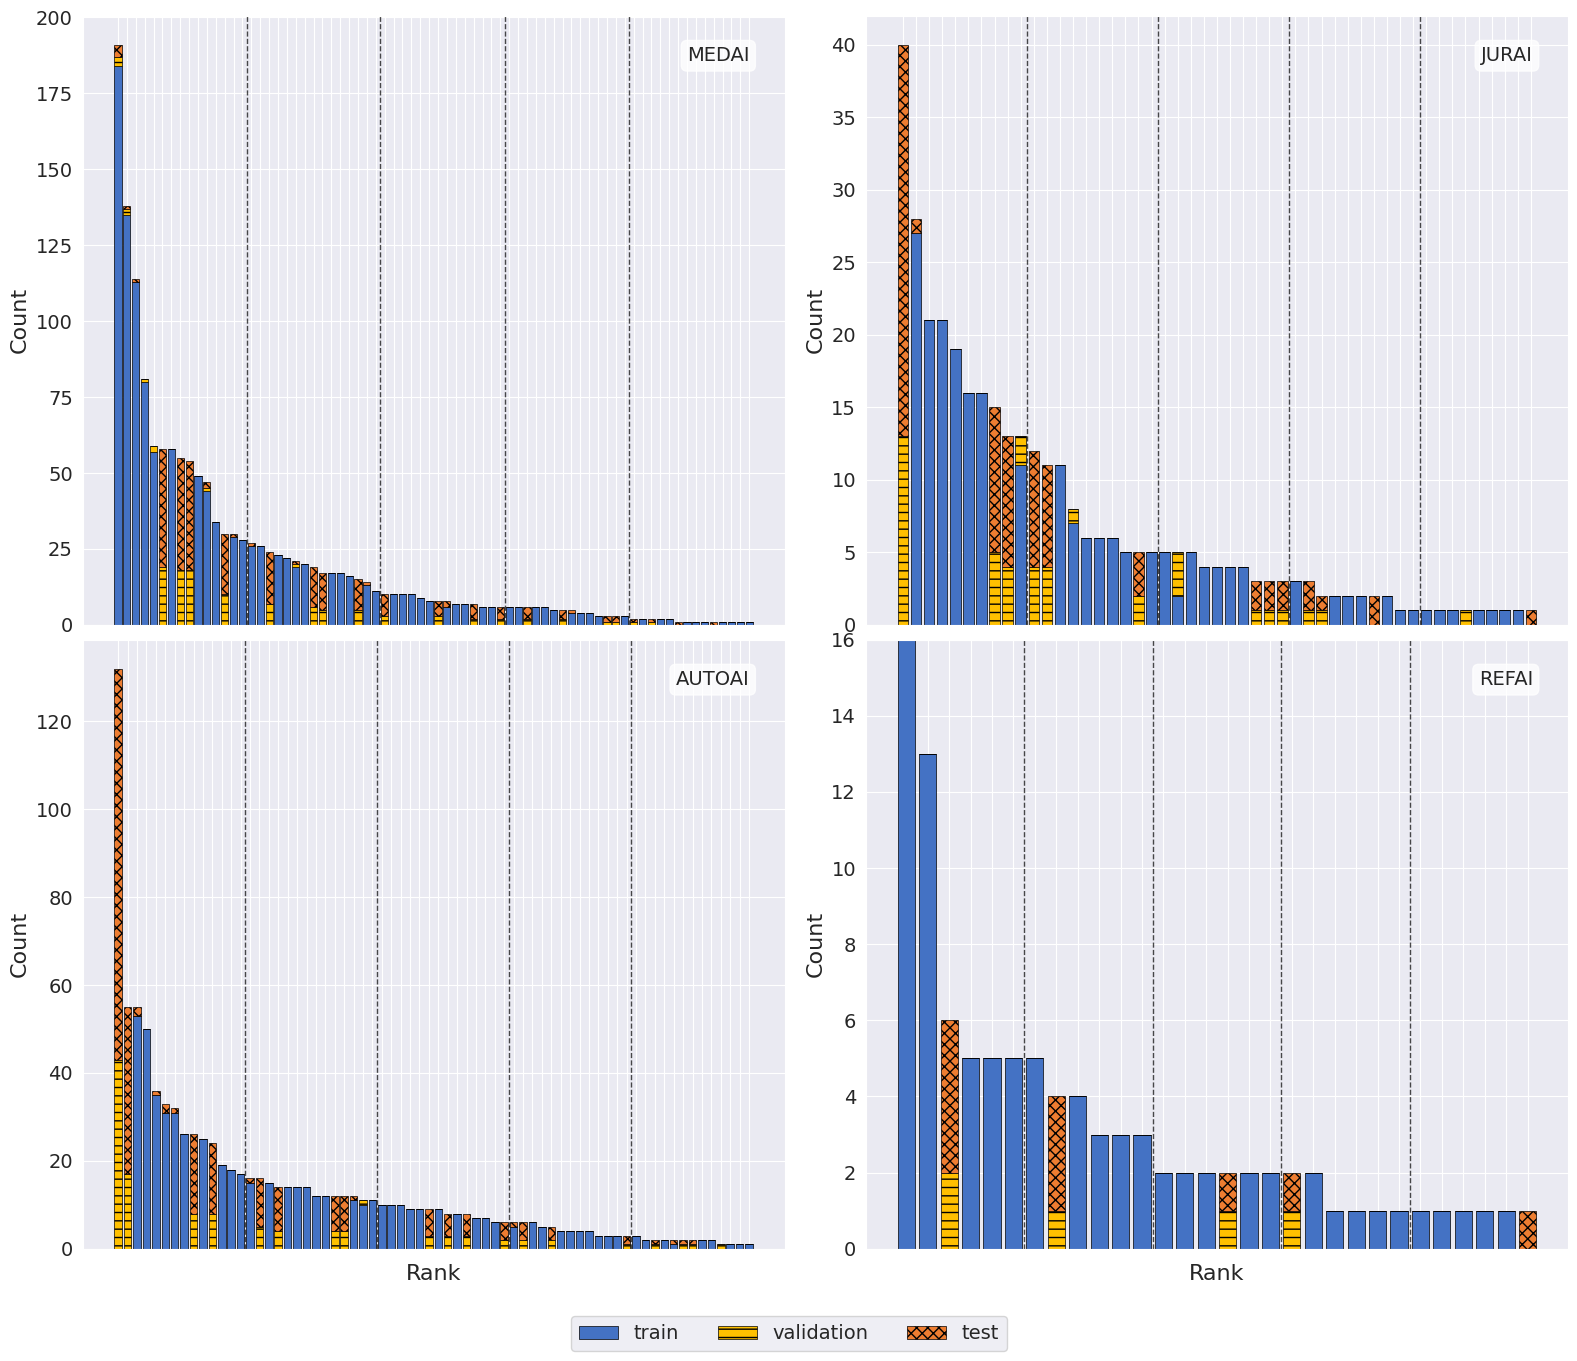

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd

# Font setup without LaTeX
plt.rcParams.update({
    "text.usetex": False,  # Disable LaTeX rendering
    # "font.family": "serif",
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12
})

# Define colors and hatching patterns for better distinction
colors = ['#4472C4', '#FFC000', '#ED7D31']  # Blue, Yellow, Red
hatches = ['', '--', 'xxx']

# Create a new figure with more subplots than we need
fig = plt.figure(figsize=(16, 14))

# Dictionary to store the media broken axis
media_axes = {}

# Plot stacked bar chart per scenario
scenarios = dataframe["scenario"].unique()
scenario_counter = 0
ax_positions = [(0, 0), (0, 1), (1, 0), (1, 1)]  # Positions for 2x2 grid

# Store handles and labels for a single legend
handles, labels = None, None

for scenario in scenarios:
    if scenario_counter >= 4:  # Ensure we only plot 4 scenarios
        break

    row, col = ax_positions[scenario_counter]

    # Create axis differently for media scenario
    if scenario == "media":
        # Create two axes for the broken axis effect
        main_ax = plt.subplot2grid((4, 2), (row*2, col), rowspan=1)
        bottom_ax = plt.subplot2grid((4, 2), (row*2+1, col), rowspan=1)
        media_axes['main'] = main_ax
        media_axes['bottom'] = bottom_ax
        ax = main_ax  # Use main_ax for code that needs to reference 'ax'
    else:
        # Regular subplot for other scenarios
        ax = plt.subplot2grid((4, 2), (row*2, col), rowspan=2)

    df_scenario = dataframe[dataframe["scenario"] == scenario]

    # Create the pivot table
    pivot_df = df_scenario.pivot(index="label", columns="split", values="count").fillna(0)
    pivot_df['total'] = pivot_df['train'] + pivot_df['validation'] + pivot_df['test']

    # Get bucket data for this scenario
    scenario_buckets_df = pd.DataFrame(ood_split_simple["buckets"])
    scenario_buckets = scenario_buckets_df[scenario_buckets_df["Scenario"] == scenario]

    # Create mappings from label to bucket and frequency
    label_to_bucket = dict(zip(scenario_buckets["label"], scenario_buckets["bucket"]))
    label_to_freq = dict(zip(scenario_buckets["label"], scenario_buckets["freq"]))

    # Add bucket information to pivot_df
    pivot_df['bucket'] = pd.Series(pivot_df.index).map(label_to_bucket).values

    # Sort by bucket and then by total within each bucket
    pivot_df = pivot_df.sort_values(['bucket', 'total'], ascending=[True, False])

    # Plot without the bucket and total columns
    plot_df = pivot_df.drop(columns=['bucket', 'total'])

    # Create the x positions
    x = np.arange(len(plot_df.index))
    width = 0.8

    # If this is the media scenario, plot in both axes with different y-limits
    if scenario == "media":
        # Plot in main axis (high values)
        bottom = np.zeros(len(plot_df.index))
        for i, (split, color, hatch) in enumerate(zip(['train', 'validation', 'test'], colors, hatches)):
            heights = plot_df[split].values
            bars = main_ax.bar(x, heights, width, bottom=bottom, label=split, color=color, edgecolor='black', linewidth=0.5)

            # Add hatching to the bars
            for bar in bars:
                bar.set_hatch(hatch)

            bottom += heights

        # Set limits for upper part - high values
        main_ax.set_ylim(20, bottom.max() * 1.1)
        main_ax.set_ylabel("Count", fontsize=16)
        main_ax.set_xticklabels([])  # Remove x labels from top plot

        # Hide x-axis line, ticks, and tick labels from the top plot
        main_ax.spines['bottom'].set_visible(False)
        main_ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

        # Plot in bottom axis (low values)
        bottom = np.zeros(len(plot_df.index))
        for i, (split, color, hatch) in enumerate(zip(['train', 'validation', 'test'], colors, hatches)):
            heights = plot_df[split].values
            bars = bottom_ax.bar(x, heights, width, bottom=bottom, label=split, color=color, edgecolor='black', linewidth=0.5)

            # Add hatching to the bars
            for bar in bars:
                bar.set_hatch(hatch)

            bottom += heights

        # Set limits for lower part - low values
        bottom_ax.set_ylim(0, 20)
        bottom_ax.set_xlabel("Rank", fontsize=16)
        bottom_ax.spines['top'].set_visible(False)

        # Add break lines
        d = .015  # how big to make the diagonal lines
        kwargs = dict(transform=main_ax.transAxes, color='k', clip_on=False)
        main_ax.plot((-d, +d), (0-d, 0+d), **kwargs)  # bottom-left diagonal
        main_ax.plot((1-d, 1+d), (0-d, 0+d), **kwargs)  # bottom-right diagonal

        kwargs.update(transform=bottom_ax.transAxes)
        bottom_ax.plot((-d, +d), (1-d, 1+d), **kwargs)  # top-left diagonal
        bottom_ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)  # top-right diagonal

        # Add vertical lines at bucket boundaries
        bucket_boundaries = []
        current_bucket = -1
        for i, (idx, row) in enumerate(pivot_df.iterrows()):
            if row['bucket'] != current_bucket:
                current_bucket = row['bucket']
                if i > 0:
                    bucket_boundaries.append(i - 0.5)

        # Add vertical lines to both plots
        for boundary in bucket_boundaries:
            main_ax.axvline(x=boundary, color='black', linestyle='--', alpha=0.7, linewidth=1)
            bottom_ax.axvline(x=boundary, color='black', linestyle='--', alpha=0.7, linewidth=1)

        # Add scenario name in the upper right corner
        main_ax.text(0.95, 0.95, scenario, transform=main_ax.transAxes,
                    fontsize=14, va='top', ha='right',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Save handles and labels from the first plot
        if scenario_counter == 0:
            handles, labels = main_ax.get_legend_handles_labels()

        # Remove legends
        if main_ax.get_legend() is not None:
            main_ax.get_legend().remove()
        if bottom_ax.get_legend() is not None:
            bottom_ax.get_legend().remove()

    else:
        # Regular plotting for other scenarios
        bottom = np.zeros(len(plot_df.index))
        for i, (split, color, hatch) in enumerate(zip(['train', 'validation', 'test'], colors, hatches)):
            heights = plot_df[split].values
            bars = ax.bar(x, heights, width, bottom=bottom, label=split, color=color, edgecolor='black', linewidth=0.5)

            # Add hatching to the bars
            for bar in bars:
                bar.set_hatch(hatch)

            bottom += heights

        # Add vertical lines at bucket boundaries
        bucket_boundaries = []
        current_bucket = -1
        for i, (idx, row) in enumerate(pivot_df.iterrows()):
            if row['bucket'] != current_bucket:
                current_bucket = row['bucket']
                if i > 0:
                    bucket_boundaries.append(i - 0.5)

        for boundary in bucket_boundaries:
            ax.axvline(x=boundary, color='black', linestyle='--', alpha=0.7, linewidth=1)

        # Set x-ticks
        ax.set_xticks(x)
        ax.set_xticklabels([])  # Remove individual labels

        # Set axis labels
        ax.set_xlabel("Rank", fontsize=16)
        ax.set_ylabel("Count", fontsize=16)

        # Add scenario name in the upper right corner
        ax.text(0.95, 0.95, scenario, transform=ax.transAxes,
                fontsize=14, va='top', ha='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Save handles and labels for the legend (from the first scenario)
        if scenario_counter == 0:
            handles, labels = ax.get_legend_handles_labels()

        # Remove the legend for individual plots
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    # Increment counter
    scenario_counter += 1

# Add a single legend at the bottom
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.02),
           ncol=3, fontsize=14)

# Adjust spacing
plt.tight_layout()
plt.subplots_adjust(bottom=0.1, hspace=0.05)  # Add space for the legend at the bottom

# Save as EPS file
plt.savefig('label_distribution.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
def check_label_distribution(df):
    """
    Checks that any (scenario, label) pair found in 'validation' or 'test'
    also exists in 'train'. If not, prints out the faulty scenario-label pairs.
    Otherwise, confirms that the distribution is valid.
    """
    # Get all (scenario, label) pairs that appear in train (count > 0)
    train_pairs = df[(df["split"] == "train") & (df["count"] > 0)][["scenario", "label"]]
    dis_allowed_pairs = set(zip(train_pairs["scenario"], train_pairs["label"]))

    # Find all pairs in test that have count > 0
    non_train = df[df["split"].isin(["test"]) & (df["count"] > 0)].copy()

    # Mark which of these are allowed
    non_train["is_allowed"] = non_train.apply(
        lambda row: (row["scenario"], row["label"]) not in dis_allowed_pairs, axis=1
    )

    # Collect the ones that are not allowed
    faulty = non_train[~non_train["is_allowed"]]

    if len(faulty) > 0:
        print("Found scenario/label pairs in test that do appear in train:")
        print(faulty[["scenario", "label", "split", "count"]])
    else:
        print("All scenario/label pairs in test are valid (they appear in train).")

check_label_distribution(dataframe)

Found scenario/label pairs in test that do appear in train:
    scenario   label split  count
232    MEDAI    Z.K7  test      1
234    MEDAI   Z.K12  test      1
235    MEDAI  NZ.K10  test      4
241    MEDAI   Z.K16  test      1
243    MEDAI   Z.K13  test      1
247    MEDAI   Z.K15  test      2
250    MEDAI    Z.K1  test      1
251    MEDAI    Z.P2  test      1
252    MEDAI   Z.K18  test      1
253    MEDAI  Z.P3-1  test      2
266    JURAI    Z.P1  test      1
277   AUTOAI   Z.C11  test      1
279   AUTOAI    Z.P9  test      1
284   AUTOAI    Z.C4  test      1
287   AUTOAI    Z.P2  test      2
288   AUTOAI    Z.P8  test      1
289   AUTOAI   Z.P12  test      2
290   AUTOAI  Z.C7-1  test      1
293   AUTOAI  Z.C3-1  test      1
